<a href="https://colab.research.google.com/github/ealeongomez/Machine-Learning/blob/main/LR_KernelAdaptativeFiltering_MK30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ealeongomez/Data

Cloning into 'Data'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (27/27), done.


In [ ]:
cd Data/

/content/Data


In [ ]:
ls

datasets_730942_1268848_sarcasmo.tsv  MK30.csv
jena_climate_2009_2016.csv.zip        PuertoBolivar.csv


In [ ]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform

tic = time.time()
plotter = 1

In [ ]:
def gaus_kernel(u,dicti,kpar):

    num    = np.linalg.norm(u-dicti, axis=1)**2
    den    = 2*kpar**2
    kernel = np.exp(-(num)/(den))[np.newaxis,:]
    return kernel

In [ ]:
file    = pd.read_csv('MK30.csv')['Values']
dataset = np.array(file)
dataset = (dataset - np.min(dataset))/(np.max(dataset)-np.min(dataset))

In [ ]:
train_set = dataset[1501:4500]     # Training data
test_set  = dataset[4601:4900]     # Testing data
N_tr      = 500                    # Number of training samples
N_te      = 100                    # Number of testing samples

In [ ]:
time_delay = 10              # Time delay (embedding length)
horizon    = 1               # Prediction horizon
eta        = 0.2             # Learning rate of Kernel Adaptative Filtering
sigma      = np.sqrt(1/2)    # Kernel bandwidth of Kernel Adaptative Filtering

In [ ]:
X_train = np.zeros([N_tr, time_delay])
for i in range(N_tr):
    X_train[i,:] = train_set[i:i+time_delay+horizon-1]
y_train = train_set[time_delay:time_delay+N_tr+horizon-1][:, np.newaxis]

X_test = np.zeros([N_te, time_delay])
for i in range(N_te):
    X_test[i,:] = test_set[i:i+time_delay+horizon-1]
y_test = test_set[time_delay:time_delay+N_te+horizon-1][:, np.newaxis]

In [ ]:
err_train_klms    = np.zeros((N_tr,1))              # Vector with errors (training)
y_train_pred_klms = np.zeros((N_tr,1))              # Vector with predictions (training)
ev_pred_klms      = np.zeros((N_tr,N_te))           # Matrix with predictions (testing)
mse_test_klms     = np.zeros((N_tr,1))              # Vector with 'MSE' values (testing)
dictionary_klms   = np.zeros((N_tr,1))              # Vector with 'size of dictionary (training)'

err_train_klms[0]    = y_train[0]                   # Init: error (training)
y_train_pred_klms[0] = 0                            # Init: prediction (training)
dicti_klms           = X_train[0,:][np.newaxis, :]  # Init: dictionary (training)
error_klms           = eta*y_train[0]               # Init: weights (training)
mse_test_klms[0]     = np.mean(y_test**2)           # Init: MSE (testing)
dictionary_klms[0]   = dicti_klms.shape[0]          # Init: size of dictionary (training) 

num_samp_pred_klms = np.zeros((N_te,1))
evol_min_dist_klms = np.zeros((N_tr,1))

n=1
while n < N_tr:
    #print('Training KLMS:','iteration ', n+1, ' of ', N_tr)
    
    "-------------------------------- TRANING --------------------------------" 
    
    "Input vector"
    u_train              = X_train[n,:][np.newaxis, :] 
    #Prediction (training)
    y_train_pred_klms[n] = np.float(eta*np.dot(gaus_kernel(u_train, dicti_klms, sigma), error_klms))
    #Compute error (training)
    err_train_klms[n]    = y_train[n] - y_train_pred_klms[n]
    
    "Update of network"
    dicti_klms           = np.append(dicti_klms,u_train,axis=0)
    error_klms           = np.append(error_klms,err_train_klms[n])
    
    "-------------------------------- TESTING --------------------------------" 
    
    y_test_pred_klms     = np.zeros((N_te,1))
    i = 0
    while i < N_te:
        "Input vector"
        u_test = X_test[i,:][np.newaxis, :]
        
        if n == N_tr-1:
            num_samp_pred_klms[i] = len(dicti_klms)
        
        #Prediction (testing)
        y_test_pred_klms[i] = np.float(eta*np.dot(gaus_kernel(u_test,dicti_klms,sigma), error_klms))
        i = i + 1  
    
    #Saving predictions
    ev_pred_klms[n,:] = y_test_pred_klms.T
    
    #Performance measure: MSE
    err_test_klms     = y_test - y_test_pred_klms
    mse_test_klms[n] = np.mean(err_test_klms**2)
    
    # Size of dictionary
    dictionary_klms[n] = dicti_klms.shape[0]
                          
    n = n + 1

toc = time.time()
print(toc-tic, 'sec Elapsed') 

223.86100316047668 sec Elapsed


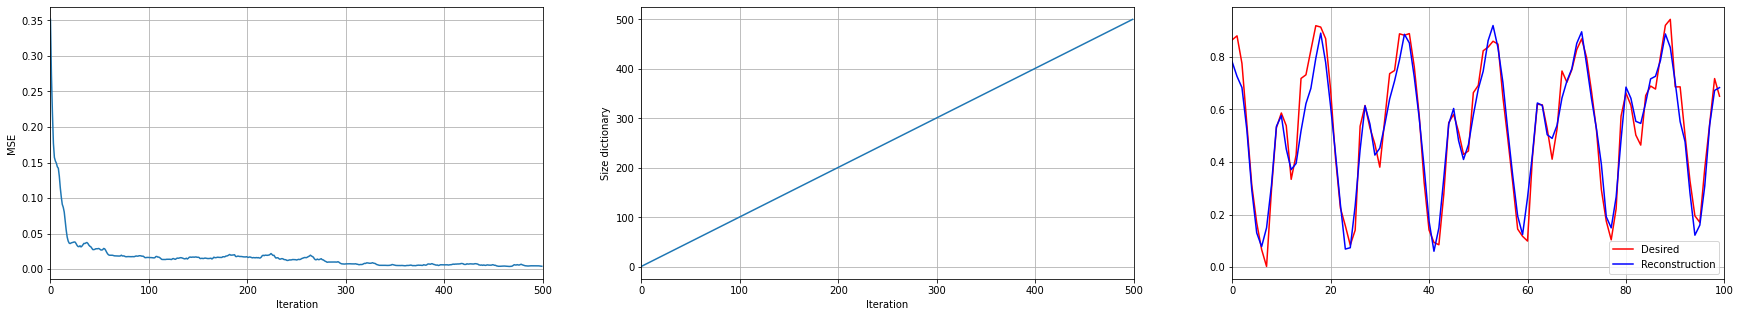

In [ ]:
plt.figure(figsize=(30,5))
plt.subplot(131)
plt.plot(mse_test_klms)
plt.xlim(0, mse_test_klms.shape[0])
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.grid()
plt.subplot(132)
plt.plot(dictionary_klms)
plt.xlim(0, dictionary_klms.shape[0])
plt.xlabel('Iteration')
plt.ylabel('Size dictionary')
plt.grid()
plt.subplot(133)
plt.plot(y_test, 'r', y_test_pred_klms, 'b')
plt.xlim(0, y_test_pred_klms.shape[0])
plt.legend(['Desired','Reconstruction'])
plt.grid()
plt.show()